# Regression
> We will use the same data used in the classification tutorial for this task (the IXI Dataset). The approach for regression tasks is nearly identical. Therefore, take a look at the classification tutorial for explanations of the various cells.

In [1]:
from fastMONAI.vision_all import *

In [2]:
path = Path('../data')

In [3]:
STUDY_DIR = download_ixi_data()

2022-08-31 19:17:23,134 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI-T1.tar.
2022-08-31 19:17:23,135 - INFO - File exists: ../data/IXI/IXI-T1.tar, skipped downloading.
2022-08-31 19:17:23,138 - INFO - Writing into directory: ../data/IXI/T1_images.
2022-08-31 19:17:29,554 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI.xls.
2022-08-31 19:17:29,554 - INFO - File exists: ../data/IXI/IXI.xls, skipped downloading.
Preprocessing ../data/IXI/IXI.xls


### Looking at the data

In [4]:
df = pd.read_csv(STUDY_DIR/'dataset.csv')
df['age'] = np.around(df.age_at_scan.tolist(), decimals=0)

In [5]:
df.head()

,t1_path,subject_id,gender,age_at_scan,age
0,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,IXI002,F,35.80,36.0
1,../data/IXI/T1_images/IXI012-HH-1211-T1.nii.gz,IXI012,M,38.78,39.0
2,../data/IXI/T1_images/IXI013-HH-1212-T1.nii.gz,IXI013,M,46.71,47.0
3,../data/IXI/T1_images/IXI014-HH-1236-T1.nii.gz,IXI014,F,34.24,34.0
4,../data/IXI/T1_images/IXI015-HH-1258-T1.nii.gz,IXI015,M,24.28,24.0


In [6]:
df.age.min(), df.age.max()

(20.0, 86.0)

In [7]:
med_dataset = MedDataset(path=STUDY_DIR/'T1_images', max_workers=12)

In [8]:
data_info_df = med_dataset.summary()

In [9]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,256,256,150,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,498
2,256,256,146,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI035-IOP-0873-T1.nii.gz,74
4,256,256,150,0.9766,0.9766,1.2,PSR+,../data/IXI/T1_images/IXI297-Guys-0886-T1.nii.gz,5
0,256,256,130,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI023-Guys-0699-T1.nii.gz,2
1,256,256,140,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI020-Guys-0700-T1.nii.gz,2


In [10]:
resample, reorder = med_dataset.suggestion()

In [11]:
bs=4
in_shape = [1, 256, 256, 160]

In [12]:
item_tfms = [ZNormalization(), PadOrCrop(in_shape[1:]), RandomAffine(scales=0, degrees=5, isotropic=False)] 

In [13]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), RegressionBlock), 
                      splitter=RandomSplitter(seed=32),
                      get_x=ColReader('t1_path'),
                      get_y=ColReader('age'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [14]:
dls = dblock.dataloaders(df, bs=bs)

In [15]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(449, 112)

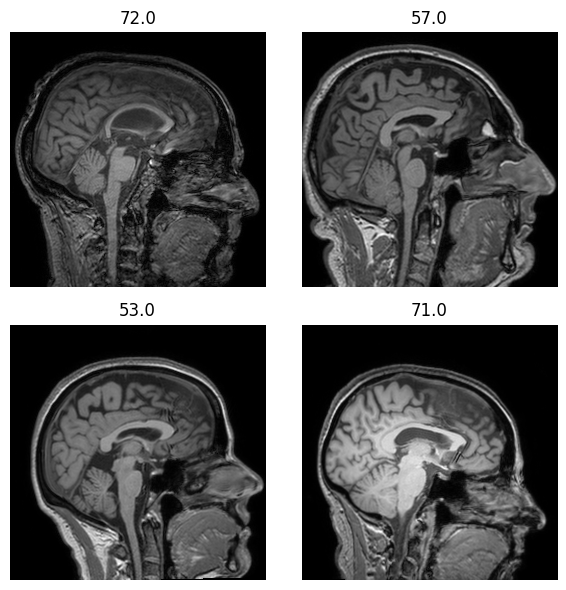

In [16]:
dls.show_batch(anatomical_plane=2)

### Create and train a 3D model

Import a network from MONAI that can be used for regression tasks, and define the input image size, the output size, channels, etc.  

In [17]:
from monai.networks.nets import Regressor
model = Regressor(in_shape=[1, 256, 256, 160], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

In [18]:
loss_func = L1LossFlat()

In [19]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[mae])

In [20]:
learn.summary()

Regressor (Input shape: 4 x 1 x 256 x 256 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 16 x 128 x 128  
Conv3d                                    448        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    448        True      
____________________________________________________________________________
                     4 x 32 x 64 x 64 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    27680      True      
InstanceNorm3d        

SuggestedLRs(valley=4.365158383734524e-05)

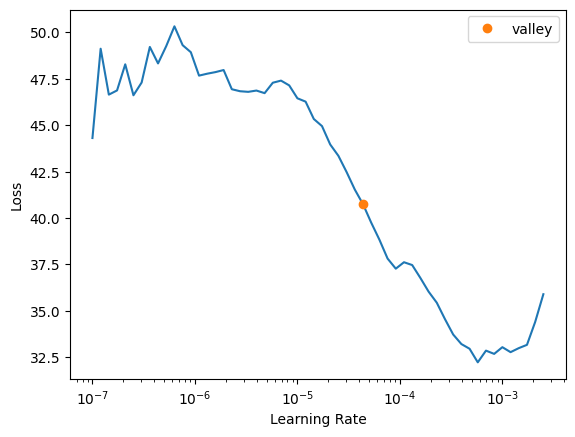

In [21]:
learn.lr_find()

In [22]:
lr = 1e-4

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mae,time
0,42.787350,26.156294,26.156294,01:06
1,19.503679,12.546371,12.546371,01:07
2,13.138490,11.939283,11.939283,01:09
3,10.076468,10.938147,10.938147,01:09


In [24]:
learn.save('model-brainage'); 

### Inference

In [25]:
learn.load('model-brainage'); 

In [26]:
interp = Interpretation.from_learner(learn)

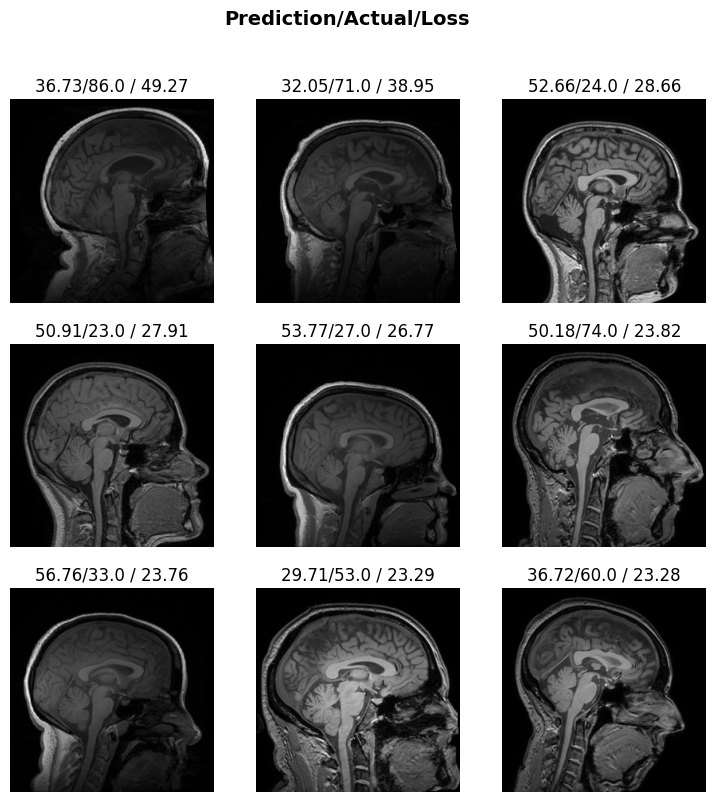

In [27]:
interp.plot_top_losses(k=9, anatomical_plane=2)